### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

import pandas as pd

### Loading the data

In [4]:
official_names = ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene']

In [5]:
components = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy.csv', skiprows=1, usecols=[0,1,2,4,5], #no menton
                      delimiter=',',dtype=float)

In [6]:
ppm_components = components[:,0]
components = components[:,1:]

In [7]:
mix = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy_bez_menthonu.csv', skiprows=1, usecols=range(2), 
                  delimiter=',',dtype=float)

In [8]:
ppm = mix[:,0]

In [9]:
mix = mix[:,1]

### Ground truth

In [10]:
#From email: 2.2449, 0.3269, 0.2533, 0.2651
r_sum = 2.2449 + 0.3269 + 0.2533 + 0.2651
molar_proportions = [2.2449/r_sum, 0.3269/r_sum, 0.2533/r_sum, 0.2651/r_sum]
print('Real proportions (molar):')
molar_proportions

Real proportions (molar):


[0.7264578344443725,
 0.10578603326645526,
 0.081968804608116,
 0.08578732768105625]

In [11]:
protons = [34, 12, 16, 16]

In [12]:
real_visible_proportions = [mol_prop*prot for mol_prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [x/sum(real_visible_proportions) for x in real_visible_proportions]
print('Proportions that should be visible in mixture computed based on number of H:')
real_visible_proportions

Proportions that should be visible in mixture computed based on number of H:


[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

### Preprocessing

In [13]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [14]:
spectra = []
for i, comp_ints in enumerate(components_ints):
    spectra.append(NMRSpectrum(confs=list(zip(ppm_components, comp_ints)), protons=protons[i]))

In [15]:
mix = NMRSpectrum(confs=list(zip(ppm,mix)))

In [16]:
spectra_and_mixture = spectra + [mix]

<IPython.core.display.Javascript object>


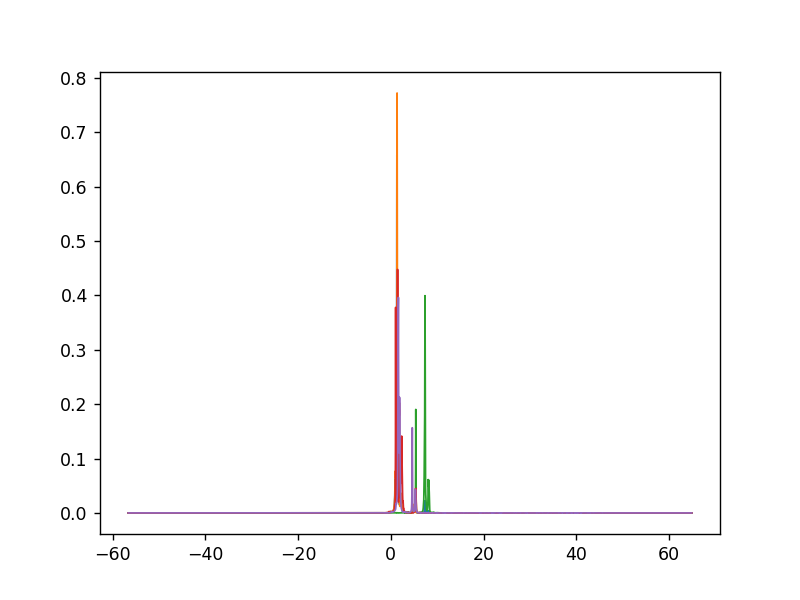

In [18]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)
spectra[3].plot(profile=True)

### Additional preprocessing for this specific case

In [19]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.NMRSpectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [20]:
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, -1.5, 10.5)

In [21]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

<IPython.core.display.Javascript object>


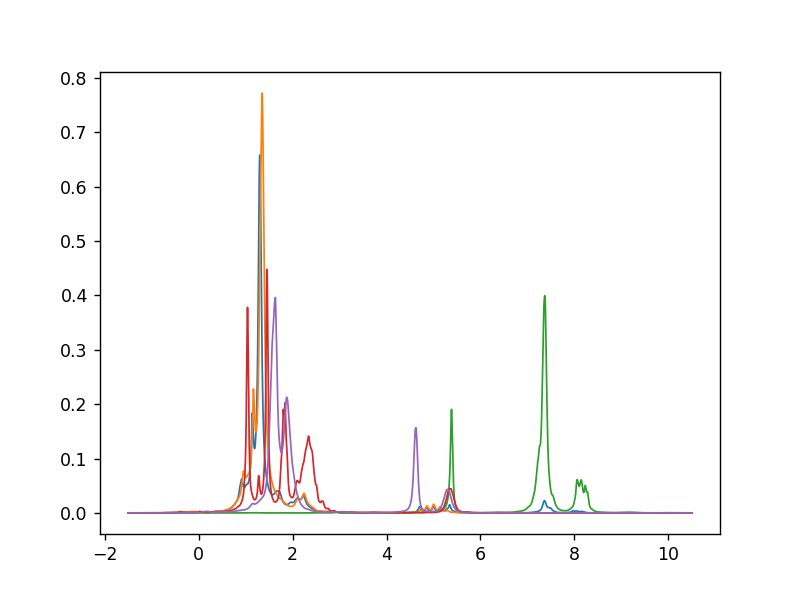

In [23]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)
spectra[3].plot(profile=True)

### Preprocessing

In [25]:
# def shift(list_of_spectra, epsilon=0.001):
#     res = list_of_spectra
#     shifted_unique = []
#     old_confs = [np.array(sp.confs) for sp in list_of_spectra]
#     min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
#     if min_of_min<0:
#         return (min_of_min - epsilon)*(-1)
#     else:
#         return(0)

In [26]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = NMRSpectrum(confs=new_confs)
    return(result)

In [27]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [28]:
spectra_and_mixture = spectra + [mix]

In [29]:
cma = common_mass_axis(spectra_and_mixture)

In [30]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [31]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [32]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [33]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [34]:
spectra_and_mixture = spectra + [mix]

In [35]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [36]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [37]:
for i, sp in enumerate(spectra):
    sp.protons = protons[i]

In [38]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


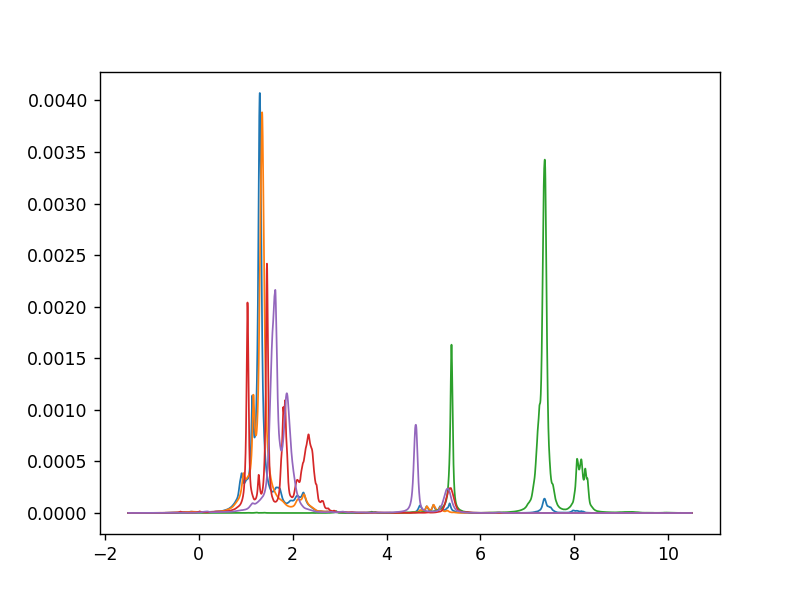

In [39]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True)

### Finding best kappa

In [40]:
import time
import pandas as pd
import pulp

In [41]:
lower_limit = 0.01
upper_limit = 0.51
step = 0.01

In [40]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

In [41]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0,comp1,comp2,comp3])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [42]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)
# #first coordinate: kappa
# #second coordinate: kappa_prime

#### Visible proportions

In [42]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa
#second coordinate: kappa_prime

In [43]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [44]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

#### Molar proportions

In [45]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [46]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [47]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [48]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

#### Both

In [49]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [50]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [51]:
all_components_results_both.min().min()

0.0667316472908416

In [52]:
all_components_results_both[0.24000000000000002][0.37]

0.0667316472908416

### Saving preprocessed spectra

In [53]:
# for i, sp in enumerate(spectra_and_mixture):
#     try:
#         np.savetxt('preprocessed_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
#     except IndexError:
#         np.savetxt('preprocessed_mix.csv', np.array(sp.confs), delimiter=',')

### Estimation with best parameters

#### Area

In [54]:
estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3], 
                                   MTD=0.37, MTD_th=0.24, verbose=True, solver=pulp.GUROBI(),
                                 what_to_compare='area')

Initial filtering of formulas: 100%|█████████████| 4/4 [00:00<00:00, 549.15it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(-1.49913, 10.4986, 0), (-1.49913, 10.4986, 1), (-1.49913, 10.4986, 2), (-1.49913, 10.4986, 3)]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 139810.13it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0]
Chunk bounds: [(-1.8691300000000002, 10.868599999999999)]


Splitting the experimental spectrum into chunks: 12449it [00:00, 3055110.32it/s]


Ion currents in chunks: [0.9999999999999991]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Deconvolving chunk 0
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49797 rows, 12452 columns and 155262 nonzeros
Model fingerprint: 0x395e03a7
Coefficient statistics:
  Matrix range     [3e-11, 1e+00]
  Objective range  [4e-09, 1e+00]
  Bounds range     [2e-03, 2e-03]
  RHS range        [3e-04, 4e-01]
Presolve removed 13456 rows and 0 columns
Presolve time: 1.96s
Presolved: 12452 rows, 49796 columns, 155261 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 9.302e+04
 Factor NZ  : 2.731e+05 (roughly 27 MB of memory)
 Factor Ops : 6.746e+06 (less than 1 second per

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.72s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.982870188361
Noise proportion in experimental spectrum: 0.017129811635999997
Total explanation: 0.9999999999970001
Noise proportion in combination of theoretical spectra: 0.017293384916


In [55]:
estimation['proportion_of_noise_in_theoretical']

0.017293384915999986

In [61]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.8619606023069992,
 0.04356239454299996,
 0.044259091624999955,
 0.03308809988599997]

In [58]:
real_visible_proportions

[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

In [59]:
old_prop = 0.017293384915999993
vortex_th_ok = np.isclose(estimation['proportion_of_noise_in_theoretical'], old_prop)
vortex_th_ok

True

In [62]:
old_estimation = [0.8619606023069997, 0.04356239454299999, 0.04425909162499998, 0.033088099885999984]
estimation_vis_ok = True
for new_est, old_est in list(zip(estimated_visible_proportions, old_estimation)):
    estimation_vis_ok = estimation_vis_ok and np.isclose(new_est, old_est)
estimation_vis_ok

True

#### Concentration

In [63]:
estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3], 
                                   MTD=0.37, MTD_th=0.24, verbose=True, solver=pulp.GUROBI(),
                                 what_to_compare='concentration')

Initial filtering of formulas: 100%|█████████████| 4/4 [00:00<00:00, 552.79it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(-1.49913, 10.4986, 0), (-1.49913, 10.4986, 1), (-1.49913, 10.4986, 2), (-1.49913, 10.4986, 3)]


Computing chunks: 100%|███████████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0]
Chunk bounds: [(-1.8691300000000002, 10.868599999999999)]


Splitting the experimental spectrum into chunks: 12449it [00:00, 2179434.45it/s]


Ion currents in chunks: [0.9999999999999991]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49797 rows, 12452 columns and 155262 nonzeros
Model fingerprint: 0x395e03a7
Coefficient statistics:
  Matrix range     [3e-11, 1e+00]
  Objective range  [4e-09, 1e+00]
  Bounds range     [2e-03, 2e-03]
  RHS range        [3e-04, 4e-01]
Presolve removed 13456 rows and 0 columns
Presolve time: 1.94s
Presolved: 12452 rows, 49796 columns, 155261 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 9.302e+04
 Factor NZ  : 2.731e+05 (roughly 27 MB of memory)
 Factor Ops : 6.746e+06 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter      

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


In [64]:
estimated_molar_proportions = estimation['proportions']
estimated_molar_proportions

[0.7496938254002201,
 0.10735096013652845,
 0.08180087488116186,
 0.0611543395820897]

In [67]:
molar_proportions

[0.7264578344443725,
 0.10578603326645526,
 0.081968804608116,
 0.08578732768105625]

In [68]:
old_estimation_molar = [0.7496938254002199,
                        0.10735096013652842,
                        0.08180087488116183,
                        0.06115433958208968]
    
estimation_molar_ok = True
for new_est, old_est in list(zip(estimated_molar_proportions, old_estimation_molar)):
    estimation_molar_ok = estimation_molar_ok and np.isclose(new_est, old_est)
estimation_molar_ok

True

In [69]:
everything_ok = (vortex_th_ok and estimation_vis_ok) and estimation_molar_ok
if everything_ok:
    print('Everything ok with estimation.')
else:
    print('Problem with:')
    print([el for el in ['vortex_th_ok', 
                        'estimation_vis_ok', 
                        'estimation_molar_ok'] if not globals()[el]])

Everything ok with estimation.


### Visualisation of our estimation

In [70]:
p = estimation['proportions']

In [71]:
p = np.array(p).reshape(len(p),1)

In [72]:
p = p[[0, 3, 1, 2],:]

In [73]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(4)]

In [74]:
components_ints = []
components_ppm = []
for spectrum in [comp0, comp3, comp1,comp2]:
    components_ints.append(np.array(spectrum.confs)[:,1].reshape(-1,1))
    components_ppm.append(np.array(spectrum.confs)[:,0])

In [75]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [76]:
X = np.concatenate(components_ints[:4], axis=1)

In [77]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

In [78]:
names_switched = [official_names[0], official_names[3], official_names[1], official_names[2]]

In [79]:
names_switched

['Isopropyl myristate', 'Limonene', 'Benzyl benzoate', 'Alpha pinene']

<IPython.core.display.Javascript object>


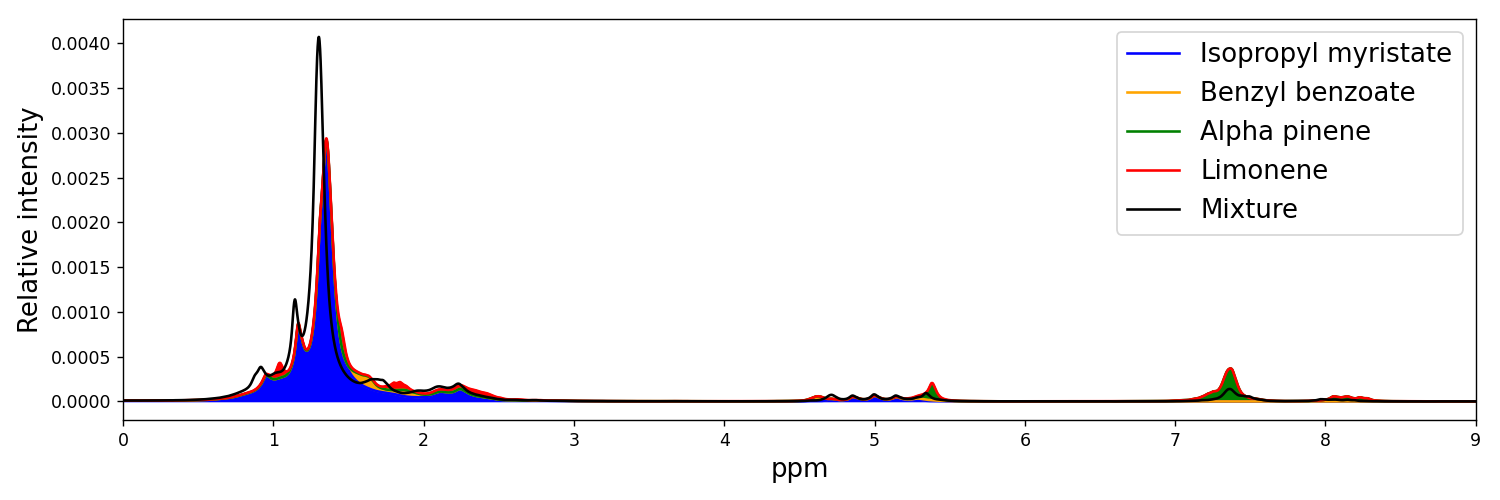

In [80]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(12, 4, forward=True)
#ax.set_xlim(4,9)
#ax.set_xlim(0.5, 2.7)
ax.set_xlim(0,9)
#ax.set_ylim(-0.0001,0.0005)

plt.xlabel('ppm', fontsize=15)
plt.ylabel('Relative intensity', fontsize=15)

for i, name in enumerate(names_matmul[:4]):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=1.5)
ax.legend(prop={'size': 15})
plt.tight_layout()
#plt.savefig('/home/basia/Documents/spectroscopy/RECOMB_magnetstein_poster/mixture_vs_estimation_exp4_entire.png', dpi=300)

### Transport plan

In [71]:
mix_estimation = np.concatenate([ppm.reshape(-1,1), globals()[names_matmul[-1]].reshape(-1,1)], axis=1)
mix_estimation = Spectrum(confs=list(zip(mix_estimation[:,0], mix_estimation[:,1])))

<IPython.core.display.Javascript object>


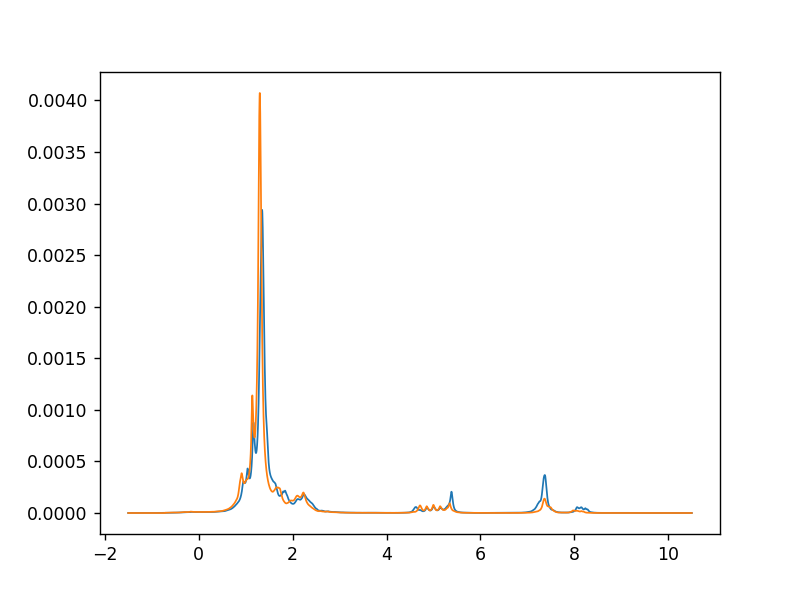

In [72]:
mix_estimation.plot(profile=True)
mix.plot(profile=True)

In [73]:
mix_estimation.normalize()

In [74]:
mix.WSDistance(mix_estimation)

0.42577372635781224

In [75]:
distances = [abs(x[0]-x[1]) for x in list(mix_estimation.WSDistanceMoves(mix))]
signals = [x[2] for x in list(mix_estimation.WSDistanceMoves(mix))]

In [76]:
distances_signals = list(zip(distances, signals))
distances_signals = pd.DataFrame(distances_signals, columns = ['Distances', 'Signals'])
distances_signals = distances_signals.groupby('Distances').agg('sum')
distances_signals.sort_index(inplace=True)

In [106]:
MTD=0.37
MTD_th=0.24

<IPython.core.display.Javascript object>


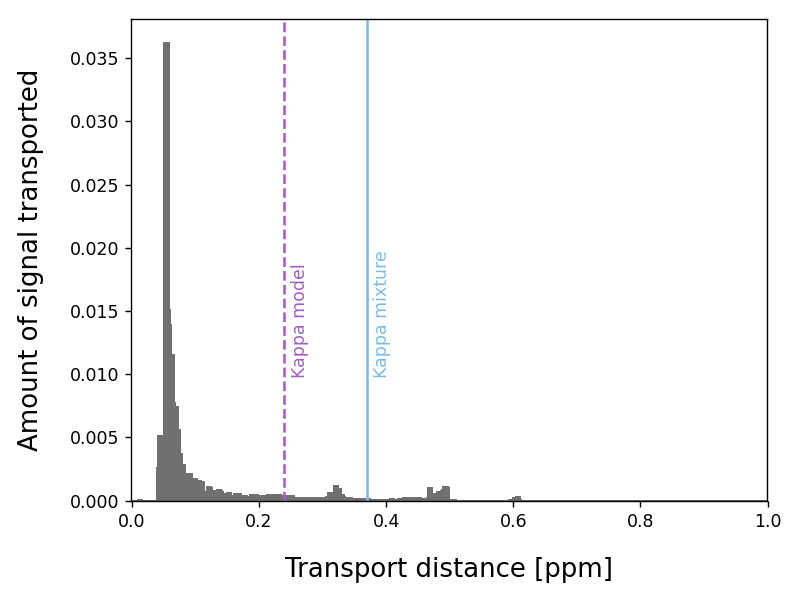

In [112]:
H, bins = distances_signals['Signals'], distances_signals.index

fig, ax = plt.subplots()
#ax.set_yscale("log")
ax.set_xlim(-0.001,1)
ax.bar(bins, H, width = 0.01, color='#707070')
#ax.bar(bins, H, width = 0.01, color='#4C6479')
#4C6479
#ax.bar(bins, H, width = 0.01, color='red')

plt.xlabel('Transport distance [ppm]', fontsize=15, labelpad=15)
plt.ylabel('Amount of signal transported', fontsize=15, labelpad=15)
#plt.xticks(np.round(bins, 5), rotation='vertical')

plt.axvline(x=MTD, color='#7EBCE1')
plt.text(MTD+0.01, 0.01,'Kappa mixture',rotation=90, color='#7EBCE1')

plt.axvline(x=MTD_th, color='#A35FC1', linestyle='--')
plt.text(MTD_th+0.01, 0.01,'Kappa model',rotation=90, color='#A35FC1')


plt.tight_layout()
plt.show()
#plt.savefig('/home/basia/Documents/spectroscopy/RECOMB_magnetstein_poster/distances_histogram_exp4.png', dpi=300)

In [107]:
percent = 0.99
q = H.quantile(q=percent)
print(str(percent*100)+'% of signal is transported on distance smaller than '+str(q)+'.' )

99.0% of signal is transported on distance smaller than 0.0009495760376923787.
